In [1]:
import numpy as np

In [2]:
av = np.load('I_355_tgextmap.npz')
av.files

['HPId', 'HPlevel', 'A0', 'e_A0', 'Ntracers']

#### The resolution of the map is defined by the NSIDE parameter, which is generally a power of 2.

In [3]:
level = 9
NSIDE = 2**level
print(NSIDE)

512


#### NPIX is the number of pixels of the map. One can find the resolution of pixels.

In [4]:
from astropy import units as u

NPIX = 12*NSIDE**2
print(NPIX)
pixres = ((4*np.pi/NPIX*u.sr)**0.5).to(u.deg)
print(pixres)

3145728
0.11451621372724687 deg


In [5]:
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle

from astropy_healpix import HEALPix

import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [6]:
HPId = av['HPId']
A0 = av['A0']

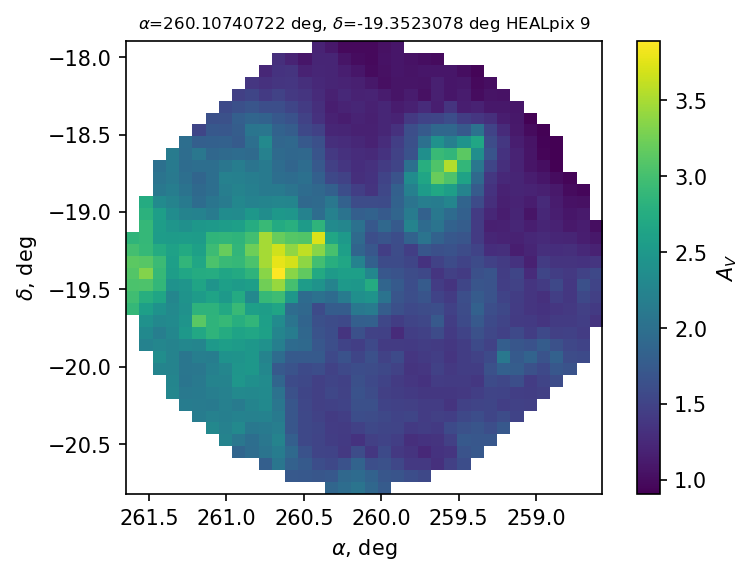

In [7]:
center = [Angle('260.10740722d'), Angle('-19.3523078d')]
coord = SkyCoord(center[0], center[1], frame='icrs', unit='deg')
RADIUS=np.sqrt(2)*u.deg

hp = HEALPix(nside=NSIDE, order='nested', frame='icrs')
search = hp.cone_search_skycoord(coord, radius=RADIUS)

local_A0 = A0[np.isin(HPId, search)]
local_HPId = HPId[np.isin(HPId, search)]

cd = hp.healpix_to_skycoord(local_HPId)
x = np.unique(cd.ra.value)
y = np.unique(cd.dec.value)
X, Y = np.meshgrid(x, y)
z = griddata((cd.ra.value,cd.dec.value), np.array(local_A0), (X, Y))

fig, ax = plt.subplots(dpi=150)
im = ax.imshow(z, cmap=plt.cm.viridis, interpolation='none', extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower')
ax.set_xlabel("$\\alpha$, deg")
ax.set_ylabel("$\\delta$, deg")
fig.colorbar(im, label="$A_V$")
ax.set_aspect('equal', adjustable='box')
ax.set_title(f"$\\alpha$={center[0]}, $\\delta$={center[1]} HEALpix {level}", fontsize=8)
ax.invert_xaxis()
plt.show()

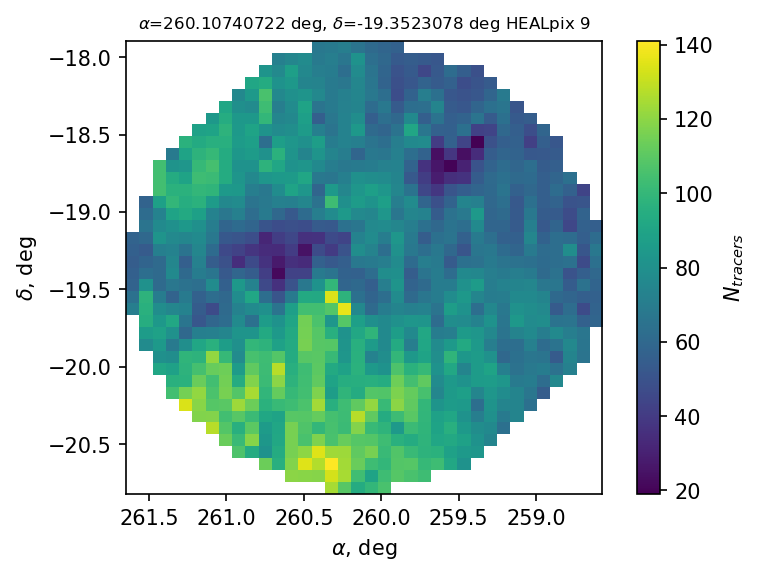

In [8]:
Ntracers=av['Ntracers']
local_Ntracers=Ntracers[np.isin(HPId,search)]

z = griddata((cd.ra.value,cd.dec.value), np.array(local_Ntracers), (X, Y))

fig, ax = plt.subplots(dpi=150)
im = ax.imshow(z, cmap=plt.cm.viridis, interpolation='none', extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower')
ax.set_xlabel("$\\alpha$, deg")
ax.set_ylabel("$\\delta$, deg")
fig.colorbar(im, label="$N_{tracers}$")
ax.set_aspect('equal', adjustable='box')
ax.set_title(f"$\\alpha$={center[0]}, $\\delta$={center[1]} HEALpix {level}", fontsize=8)
ax.invert_xaxis()
plt.show()

In [9]:
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = 3000000
r = Gaia.query_object_async(coordinate=coord, radius=RADIUS, columns=['ra','dec'])
r

INFO: Query finished. [astroquery.utils.tap.core]


ra,dec,dist
deg,deg,
float64,float64,float64
260.10723978005575,-19.351757117406294,0.0005701071646158488
260.1066152194342,-19.35222783471589,0.0007581078280948781
260.10595372421005,-19.351670813690983,0.0015164756456129869
260.1057177232728,-19.352287517178297,0.0016012527063198555
260.10715751882105,-19.3506133478467,0.0017067896587293309
260.1063234391951,-19.35027164381998,0.0022772393568919694
260.1068778833331,-19.354843881593624,0.0025910929068233986
260.1092188083879,-19.350295246483306,0.0026319900438694227


In [10]:
local_Nstars = np.zeros(len(local_HPId))
for pixid in range (len(local_HPId)):
    pixra = cd[pixid].ra
    pixdec = cd[pixid].dec
    local_mask = (r['ra'] > pixra-pixres/2) & (r['ra'] < pixra+pixres/2) & (r['dec'] > pixdec-pixres/2) & (r['dec'] < pixdec+pixres/2)
    local_Nstars[pixid] = len(r[local_mask])

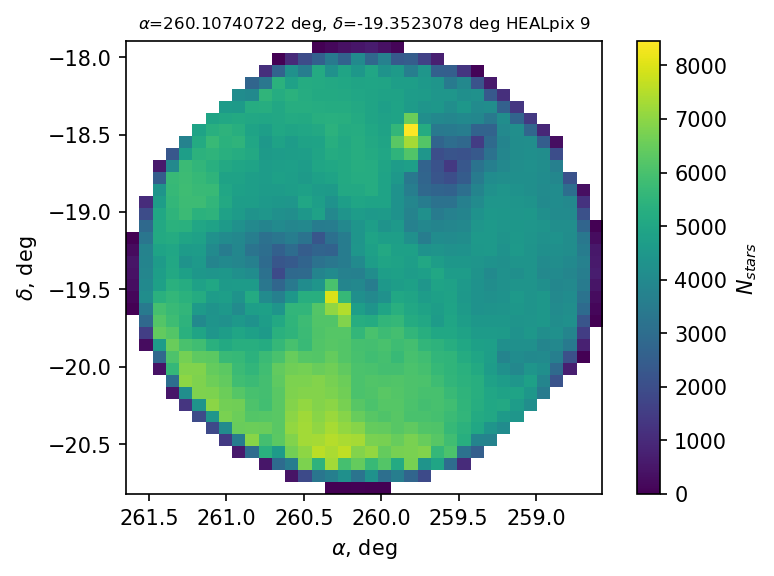

In [11]:
z = griddata((cd.ra.value,cd.dec.value), local_Nstars, (X, Y))

fig, ax = plt.subplots(dpi=150)
im = ax.imshow(z, cmap=plt.cm.viridis, interpolation='none', extent=[X.min(), X.max(), Y.min(), Y.max()], origin='lower')
ax.set_xlabel("$\\alpha$, deg")
ax.set_ylabel("$\\delta$, deg")
fig.colorbar(im, label="$N_{stars}$")
ax.set_aspect('equal', adjustable='box')
ax.set_title(f"$\\alpha$={center[0]}, $\\delta$={center[1]} HEALpix {level}", fontsize=8)
ax.invert_xaxis()
plt.show()